In [1]:
import os
import numpy as np
import moviepy.editor as mpe

import tensorflow as tf
from tensorflow.python.framework import ops

from load_data import *
from models.customlayers import *
from models.activations import *
from training import *

import models.ConvAE as cae
L = tf.layers

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
data_dir = os.path.expanduser('~/Insight/video-representations/data/downsampled')
# X_train, y_train, X_test, y_test = get_splits(*load_all_data_stacked(data_dir, every_n=2))
X, y = load_all_data_stacked(data_dir, every_n=8)

In [3]:
tf.reset_default_graph()

input_var = tf.placeholder(dtype=tf.float32, shape=(None, 3, 60, 80), name='input')
target_var = tf.placeholder(dtype=tf.float32, shape=(None, 3, 60, 80), name='target')
l2_weight = .01

with tf.variable_scope('encoder'):
    encoded = cae.encoder(input_var)

# with tf.variable_scope('latent'):
#     latent = L.dense(encoded, units=1024, activation=selu)

with tf.variable_scope('decoder'):
    decoded = cae.decoder(encoded)

l2_term = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'bias' not in v.name])
loss = tf.reduce_mean(tf.pow(decoded - target_var, 2))
train_step = tf.train.AdamOptimizer().minimize(loss + l2_weight*l2_term)
saver = tf.train.Saver()
init = tf.global_variables_initializer()

[None, 48, 68, 32]
104448
(?, 104448)


In [4]:
print('Training data: {} examples, {:.2f} GB'.format(X_train.shape[0], X_train.nbytes/1000000))

Training data: 69917 examples, 4027.22 GB


In [ ]:
os.makedirs('tmp/models', exist_ok=True)
epochs = 30

with tf.Session() as sesh:
    
    sesh.run(init)
        
    train_trace = []
    validation_trace = []
    
    batch_no = 0
    current_loss = 0
    
    for batch in iterate_minibatches(X_test, y_test, batchsize=128):
        X_batch, y_batch = batch
        current_loss += loss.eval({input_var: X_batch, target_var: y_batch})
        batch_no += 1
        
    print('Initial loss:\t{}'.format(current_loss / batch_no))
    saver.save(sesh, 'tmp/models/prototype_ae initial.ckpt')
    
    for epoch in range(epochs):
        batch_no = 0
        current_loss = 0
        
        for batch in iterate_minibatches(X_train, y_train, batchsize=64, shuffle=True):
            X_batch, y_batch = batch
            _, batch_loss = sesh.run([train_step, loss], {input_var: X_batch, target_var: y_batch})
            
            current_loss += batch_loss
            batch_no += 1
            train_trace.append(batch_loss)
            
            if batch_no % 200 == 0:
                print('\t\t', current_loss / batch_no)
            
        print('Epoch {} train loss:\t{}'.format(epoch, current_loss / batch_no))
        
        val_loss = 0
        batch_no = 0
        
        for batch in iterate_minibatches(X_test, y_test, batchsize=128, shuffle=True):
            X_batch, y_batch = batch
            
            batch_loss = loss.eval({input_var: X_batch, target_var: y_batch})
            val_loss += batch_loss
            batch_no += 1
            
        print('\t test loss:\t{}'.format(val_loss / batch_no))
    
    train_outputs = []
    for batch in iterate_minibatches(X_train, y_train, batchsize=128, shuffle=False):
        X_batch, y_batch = batch
        output = sesh.run(decoded, {input_var: X_batch})
        train_outputs.append(output)
    
    test_outputs = []
    for batch in iterate_minibatches(X_test, y_test, batchsize=128, shuffle=False):
        X_batch, y_batch = batch
        output = sesh.run(decoded, {input_var: X_batch})
        test_outputs.append(output)
    
    saver.save(sesh, 'tmp/models/prototype_ae.ckpt')

Initial loss:	14286.469124348958
		 2890.04278259
		 2285.76322571
		 2041.99288411
		 1897.1128476
		 1784.06570593
Epoch 0 train loss:	1740.819364387037
	 test loss:	1309.4410013834636
		 1193.18520538
		 1183.96714752
		 1166.28572184
		 1154.43309433
		 1146.81724615
Epoch 1 train loss:	1143.0116882324219
	 test loss:	1126.7654978434246
		 1051.19827209
		 1047.05859085
		 1046.74722992
		 1049.1889946
		 1047.44044025
Epoch 2 train loss:	1047.0075389596568
	 test loss:	1073.7119405110677
		 966.33474884
		 972.090694885
		 976.733774414
		 976.266668091
		 979.410899719
Epoch 3 train loss:	980.1446906568367
	 test loss:	1027.1083811442056
		 895.016418457
		 903.397529907
		 912.111586405
		 914.858588104
		 917.1052052
Epoch 4 train loss:	918.3992142450242
	 test loss:	1019.0979553222656
		 841.924283752
		 844.993510742
		 852.524325562
		 865.722785416
		 872.809816895
Epoch 5 train loss:	876.9769640353137
	 test loss:	1021.0498647054036
		 805.518874817
		 807.781499023
		 816

In [4]:
with tf.Session() as sesh:
    saver.restore(sesh, 'tmp/models/prototype_ae.ckpt')
        
    outputs = []
    for batch in iterate_minibatches(X, y, batchsize=128, shuffle=False):
        X_batch, y_batch = batch
        output = sesh.run(decoded, {input_var: X_batch})
        outputs.append(output)

INFO:tensorflow:Restoring parameters from tmp/models/prototype_ae.ckpt


In [33]:
lim = 100
startloc = 5000
new_test_frames = np.concatenate(outputs).transpose((0, 2, 3, 1))[startloc:startloc+lim]
orig_test_frames = X[startloc:startloc+lim].transpose((0, 2, 3, 1))
# new_train_frames = np.concatenate(train_outputs[:lim]).transpose((0, 2, 3, 1))
# X_test_ims = X_test[:lim].transpose((0, 2, 3, 1))
# X_train_ims = X_train[:lim].transpose((0, 2, 3, 1))

In [34]:
clipped_frames = np.minimum(np.maximum(new_test_frames, 0), 256)
orig_clipped_frames = np.minimum(np.maximum(orig_test_frames, 0), 256)

In [35]:
orig_test_frames.shape

(100, 60, 80, 3)

In [36]:
new_test_frames.shape

(100, 60, 80, 3)

In [41]:
clip = mpe.ImageSequenceClip(list(clipped_frames), fps=2)
clip.write_videofile('./test.mp4')

[MoviePy] >>>> Building video ./test.mp4
[MoviePy] Writing video ./test.mp4


 99%|█████████▉| 100/101 [00:00<00:00, 1568.77it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test.mp4 



In [40]:
d

50.0

In [38]:
clip_orig = mpe.ImageSequenceClip(list(orig_clipped_frames), fps=2)
clip_orig.write_videofile('.test_orig.mp4')

[MoviePy] >>>> Building video .test_orig.mp4
[MoviePy] Writing video .test_orig.mp4


 99%|█████████▉| 100/101 [00:00<00:00, 140.72it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: .test_orig.mp4 



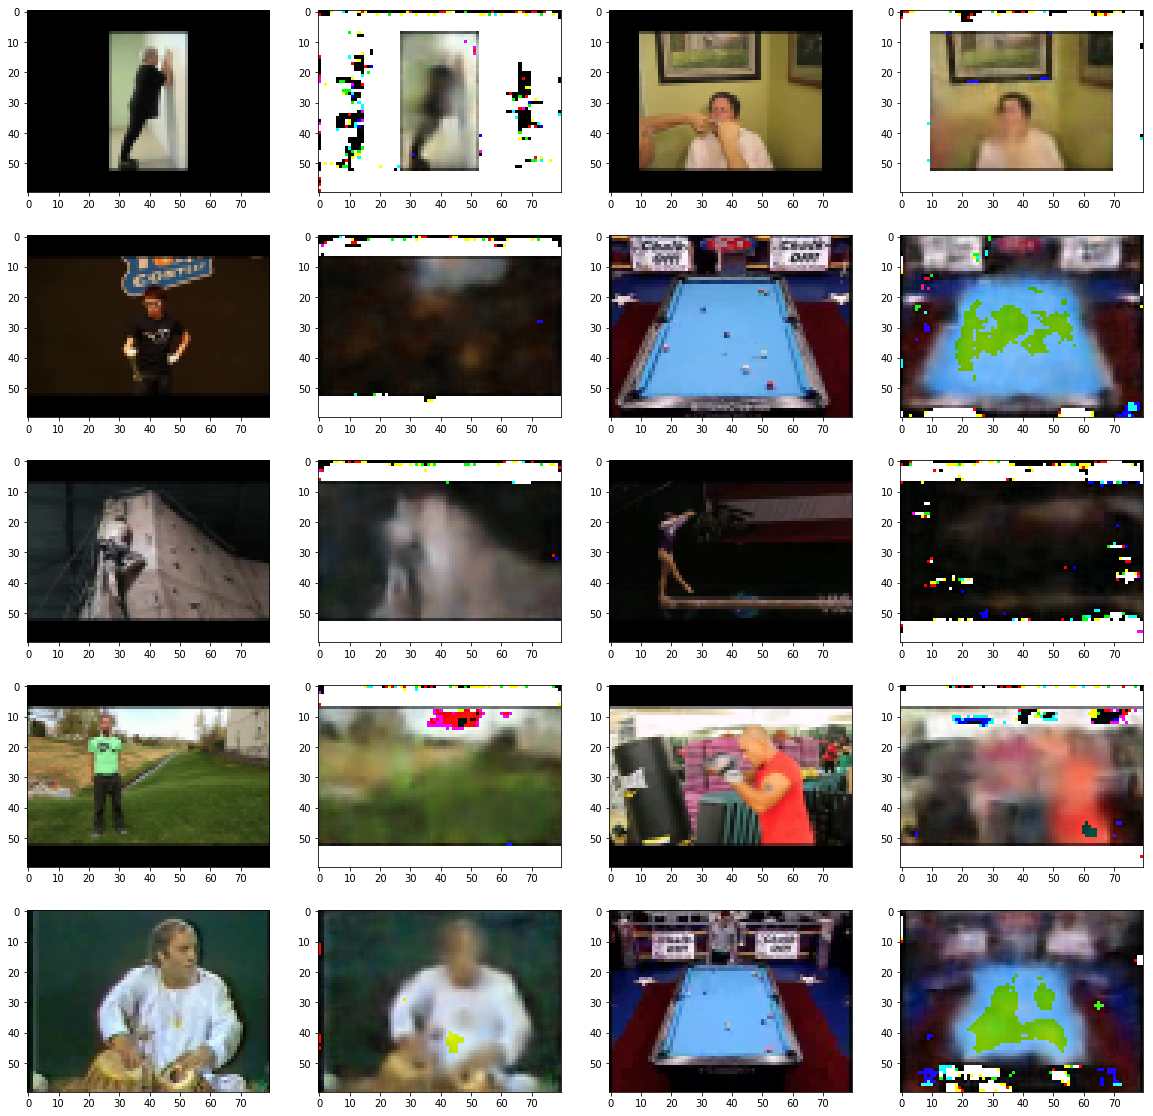

In [8]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
probe = 4

for i in range(5):
    for j in range(4):
        ax = axes[i, j]
        if j == 0:
            ax.imshow(X_train_ims[probe+(i//5)+2*i])
        elif j == 1:
            ax.imshow(new_train_frames[probe+(i//5)+2*i])
        elif j == 2:
            ax.imshow(X_test_ims[probe+(i//5)+2*i])
        else:
            ax.imshow(new_test_frames[probe+(i//5)+2*i])